### Use `RGBD` camera

In [2]:
import mujoco,cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

from model.mujoco_parser import MuJoCoParserClass
from model.util import sample_xyzs,rpy2r,r2rpy,compute_view_params,get_interp_const_vel_traj
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.4]


### Parse `UR5e` with `RG2` gripper

In [3]:
xml_path = '../asset/ur5e/scene_ur5e_rg2_obj.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=True)
obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)
# Place objects
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[0.45,1.65],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    env.model.geom(geomadr).rgba = colors[obj_idx] # color

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0,0,0.8])
print ("Ready.")

dt:[0.0020] HZ:[500]
n_body:[52]
geom_names:['floor', None, None, None, None, None, 'ur_shoulder_link_collision', None, None, None, None, 'ur_upper_arm_link_1_collision', 'ur_upper_arm_link_2_collision', None, None, None, None, 'ur_forearm_link_1_collision', 'ur_forearm_link_2_collision', None, None, None, 'ur_wrist_1_link_collision', None, None, None, 'ur_wrist_2_link_1_collision', 'ur_wrist_2_link_2_collision', None, 'ur_wrist_3_link_collision', 'ur_tcp_link_collision', 'camera_mount_collision', 'camera_mounted_gear_collision', 'ur_rg2_gripper_base_link_collision', 'camera_center_collision', 'ur_rg2_gripper_finger1_finger_link_collision', 'ur_rg2_gripper_finger1_inner_knuckle_link_collision', 'ur_rg2_gripper_finger1_finger_tip_link_collision', 'ur_rg2_gripper_finger2_finger_link_collision', 'ur_rg2_gripper_finger2_inner_knuckle_link_collision', 'ur_rg2_gripper_finger2_finger_tip_link_collision', 'front_object_table', 'side_object_table', 'base_table', 'obj_cylinder_01', 'obj_cylinder

In [4]:
joint_names = env.rev_joint_names[:6]
idxs_forward = [env.model.joint(joint_name).qposadr[0] for joint_name in env.joint_names[:6]]
idxs_jacobian = [env.model.joint(joint_name).dofadr[0] for joint_name in env.joint_names[:6]]
list1, list2 = env.ctrl_joint_idxs, idxs_forward
idxs_step = []
for i in range(len(list2)):
    if list2[i] in list1:
        idxs_step.append(list1.index(list2[i]))
        

### Render

In [29]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=66.08,distance=3.0,elevation=-50,lookat=[0.4,0.18,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

# Base pose
body_name = 'tcp_link'
p_base = env.get_p_body(body_name='base')

# Straight pose
DO_RENDER_IK = False
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,0,0]))@rpy2r(np.radians([-180,0,90]))
rev_joint_idxs = [0,1,2,3,4,5]
q_prepose_00 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=np.radians([0,-90,0,0,0,0]),idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=10,th=1*np.pi/180.0,err_th=1e-2)

# 30 deg down pose
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,30,0]))@rpy2r(np.radians([-180,0,90]))
rev_joint_idxs = [0,1,2,3,4,5]
q_prepose_30 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=q_prepose_00,idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=10,th=1*np.pi/180.0,err_th=1e-4)

# 60 deg down pose
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,60,0]))@rpy2r(np.radians([-180,0,90]))
rev_joint_idxs = [0,1,2,3,4,5]
q_prepose_60 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=q_prepose_30,idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=10,th=1*np.pi/180.0,err_th=1e-4)

print ("IK done.")

# Get joint trajectory
times,q_traj = get_interp_const_vel_traj(
    np.vstack((q_prepose_60,q_prepose_30,q_prepose_00,q_prepose_30,q_prepose_60)),
    vel=np.radians(30),HZ=env.HZ)
print ("q_traj's L:[%d] time_max:[%.2f]sec"%(times.shape[0],times[-1]))

# Reset
env.reset()
env.forward(q=q_traj[0,:],joint_idxs=[0,1,2,3,4,5])
tick,max_sec = 0,100
while env.get_sim_time() <= max_sec:
    # Step
    env.step(ctrl=q_prepose_60,ctrl_idxs=idxs_step)
    tick = min(tick + 1,q_traj.shape[0]-1)
    if not env.is_viewer_alive(): break
        
    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2]
        
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=30,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        # Render
        env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.2,axis_width=0.005)
        env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
        for p in pcd: env.plot_sphere(p=p,r=0.005,rgba=[0.95,0.05,0.05,1])
        # env.update_viewer(distance=2.0,lookat=p_cam) # update viewer
        env.render(render_every=1)
        
    # Plot
    if env.loop_every(HZ=1):
        fig,axs = plt.subplots(1,3,figsize=(10,2))
        scene_img = env.grab_image()
        axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)  
        fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=11)
        plt.subplots_adjust(wspace=0.2); plt.show()
        
# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

IK done.
q_traj's L:[2861] time_max:[5.72]sec
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Pressed ESC
Quitting.
Done. Tick:[477] Time:[0.95]sec


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def project_XY(cleaned_point_cloud, edge = 0.01, SAVE=None):
    # assume cleaned_point_cloud is the cleaned point cloud as a numpy array with shape (n_points, 3)

    # project points onto the XY plane by ignoring the Z coordinate
    projected_points = cleaned_point_cloud[:, [1,0]]

    # compute extent of points in XY plane
    min_x, min_y = np.min(projected_points, axis=0)
    max_x, max_y = np.max(projected_points, axis=0)

    # compute center of circle
    center_x, center_y = (min_x + max_x) / 2, (min_y + max_y) / 2

    # compute radius of circle
    radius = (max_x - min_x)/ 2
    # plot the circle and points
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.scatter(projected_points[:, 0], projected_points[:, 1], s=1, c='k')
    # circle = plt.Circle((center_x, center_y), radius, fill=False)
    
    plt.xlim(center_x-radius-edge, center_x+radius+edge)
    plt.ylim(center_y-radius-edge, center_y+radius+edge)

    if SAVE is not None:
        plt.axis("off")
        plt.savefig(SAVE, pad_inches=0, bbox_inches='tight', transparent=True)
    plt.axis('on')

    info = dict(center_x = center_x, center_y = center_y, radius = radius, edge = edge)
    return ax,fig, info

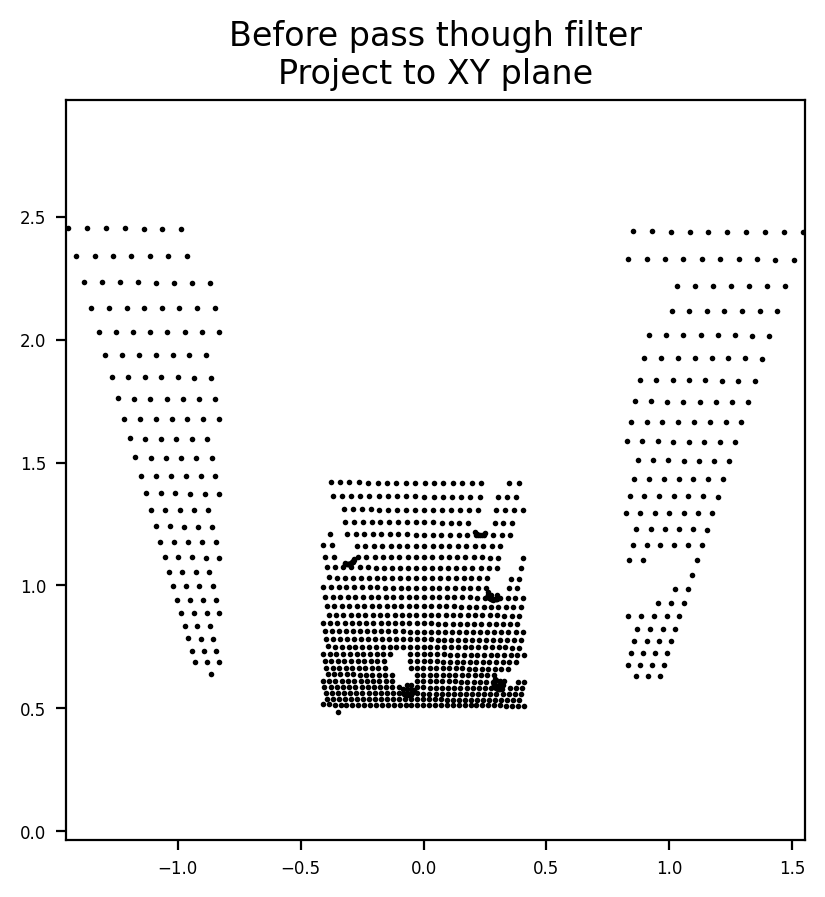

In [7]:
project_XY(pcd, edge = 0.01, SAVE= None)
plt.title("Before pass though filter\n"+'Project to XY plane')
plt.show()

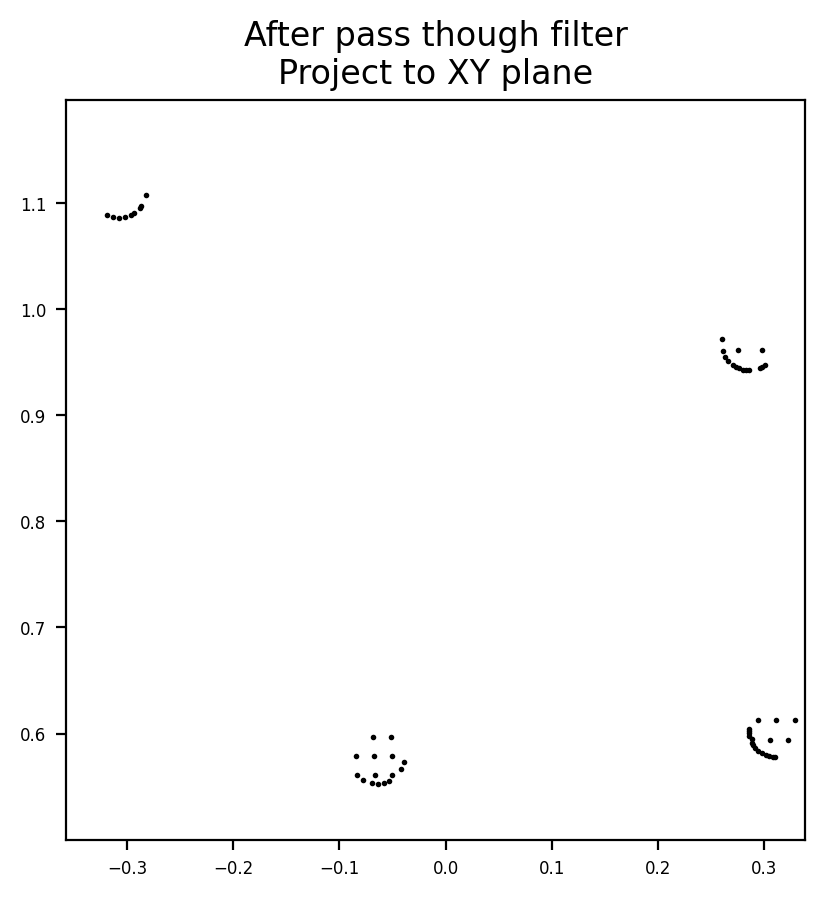

In [8]:
# Set the range limits for the passthrough filter along a specific axis
axis = 2  # 0 for x-axis, 1 for y-axis, 2 for z-axis
min_limit = 0.9
max_limit = 1.5

# Apply the passthrough filter along the specified axis
filtered_pcd = pcd[(pcd[:, axis] >= min_limit) & (pcd[:, axis] <= max_limit)]
project_XY(filtered_pcd, edge = 0.01, SAVE= './data/proj_xy_pcd.png')
plt.title("After pass though filter\n"+'Project to XY plane')
plt.show()

In [9]:
# %%
def project_YZ(cleaned_point_cloud, edge=0.02, VIZ=False):
    # assume cleaned_point_cloud is the cleaned point cloud as a numpy array with shape (n_points, 3)

    # project points onto the XY plane by ignoring the Z coordinate
    projected_points = cleaned_point_cloud[:, [1,2]]

    # compute extent of points in XY plane
    min_x, min_y = np.min(projected_points, axis=0)
    max_x, max_y = np.max(projected_points, axis=0)

    # compute center of circle
    center_x, center_y = (min_x + max_x) / 2, (min_y + max_y) / 2

    # compute radius of circle
    radius = max((max_x - min_x), (max_y - min_y)) / 2

    # plot the circle and points
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.scatter(projected_points[:, 0], projected_points[:, 1], s=1)
    circle = plt.Circle((center_x, center_y), radius, fill=False)
    ax.add_artist(circle)

    if VIZ:
        plt.xlim(center_x-radius-edge, center_x+radius+edge)
        plt.ylim(center_y-radius-edge, center_y+radius+edge)
        plt.axis('equal')
        # plt.show()
    center_z = (min_y+max_y)/2
    return center_z

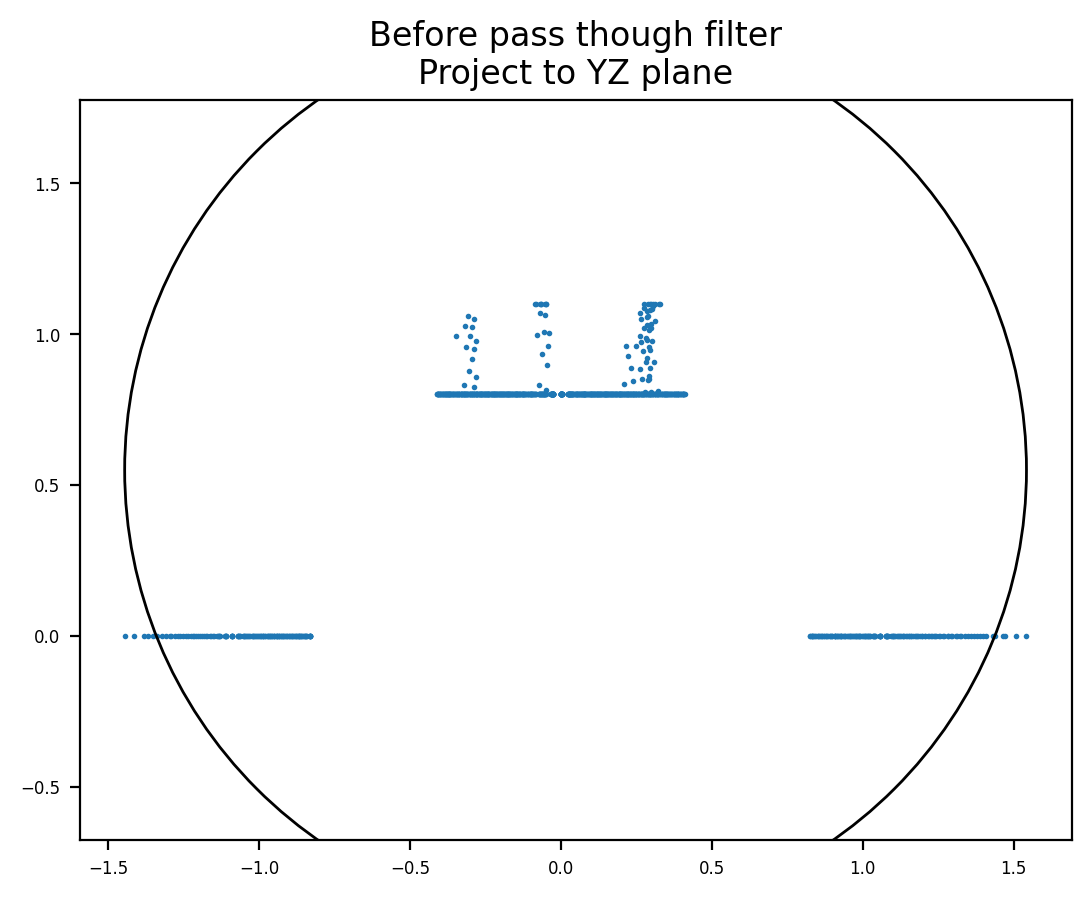

In [10]:
project_YZ(pcd, edge = 0.01, VIZ= True)
plt.title("Before pass though filter\n"+'Project to YZ plane')
plt.show()

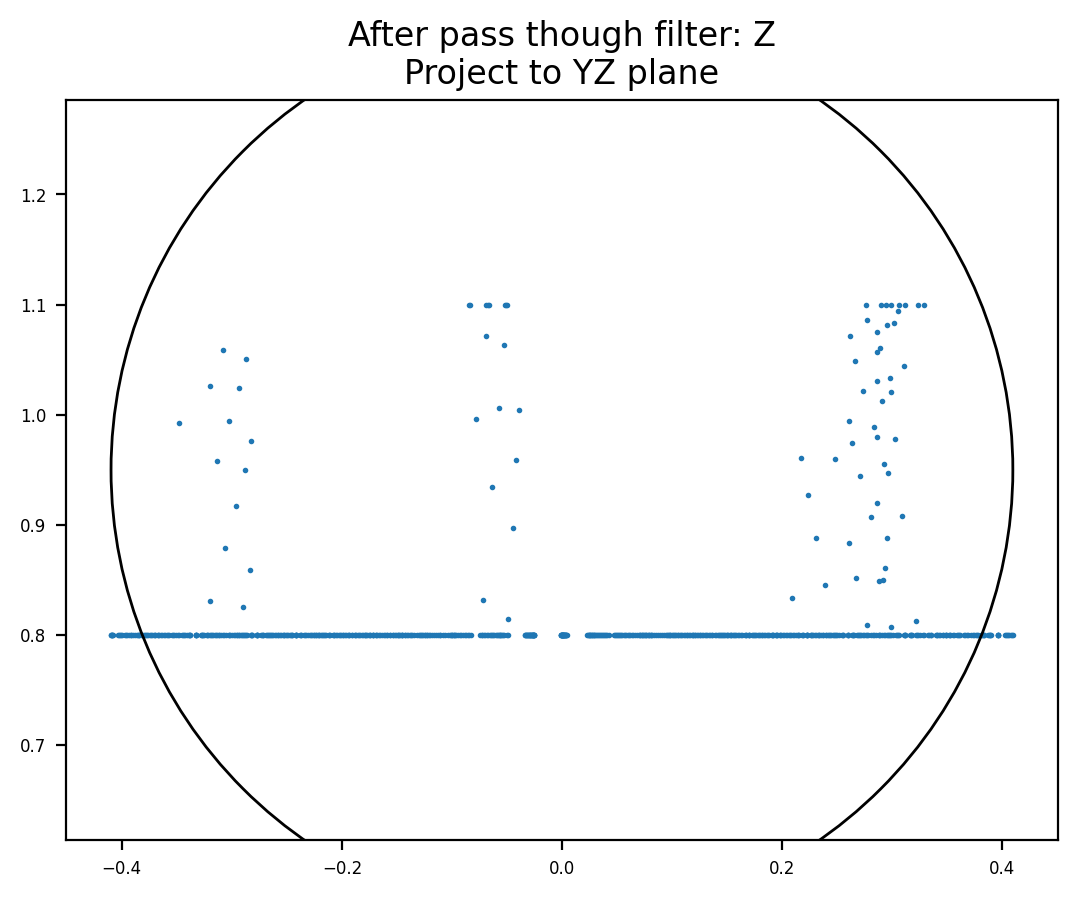

In [11]:
# Set the range limits for the passthrough filter along a specific axis
axis = 2  # 0 for x-axis, 1 for y-axis, 2 for z-axis
min_limit = 0.3
max_limit = 1.5

# Apply the passthrough filter along the specified axis
filtered_pcd = pcd[(pcd[:, axis] >= min_limit) & (pcd[:, axis] <= max_limit)]
project_YZ(filtered_pcd, edge = 0.01, VIZ= True)
plt.title("After pass though filter: Z\n"+'Project to YZ plane')
plt.show()

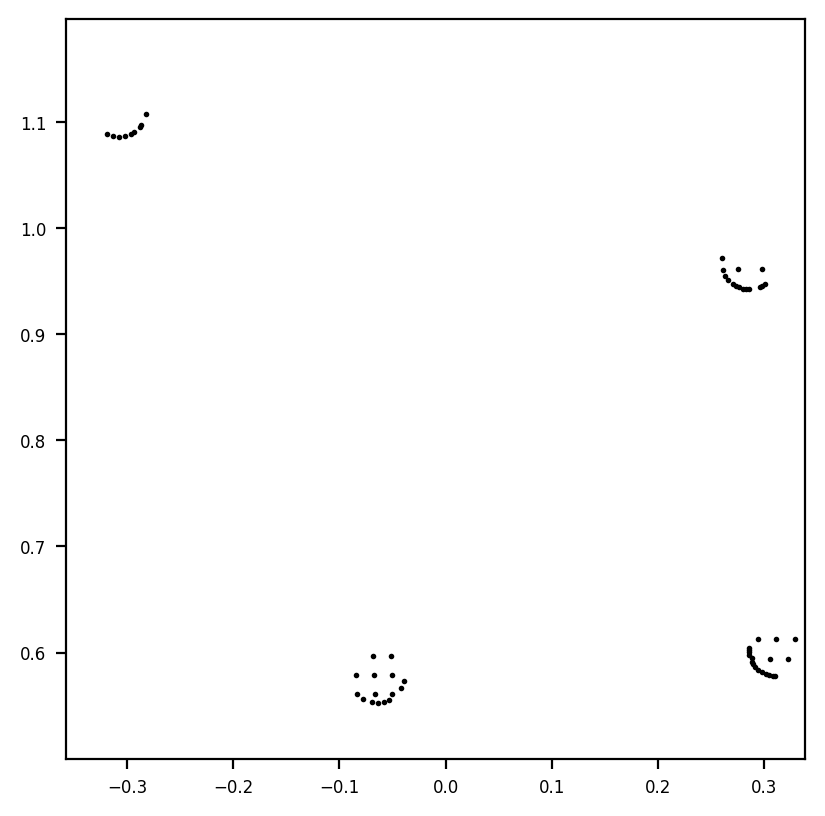

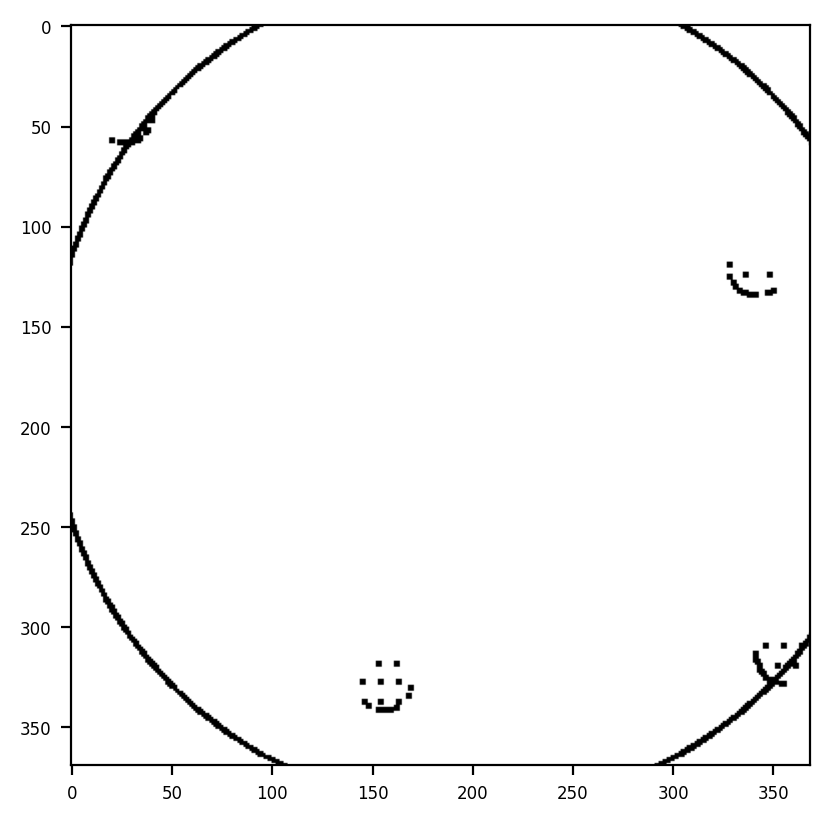

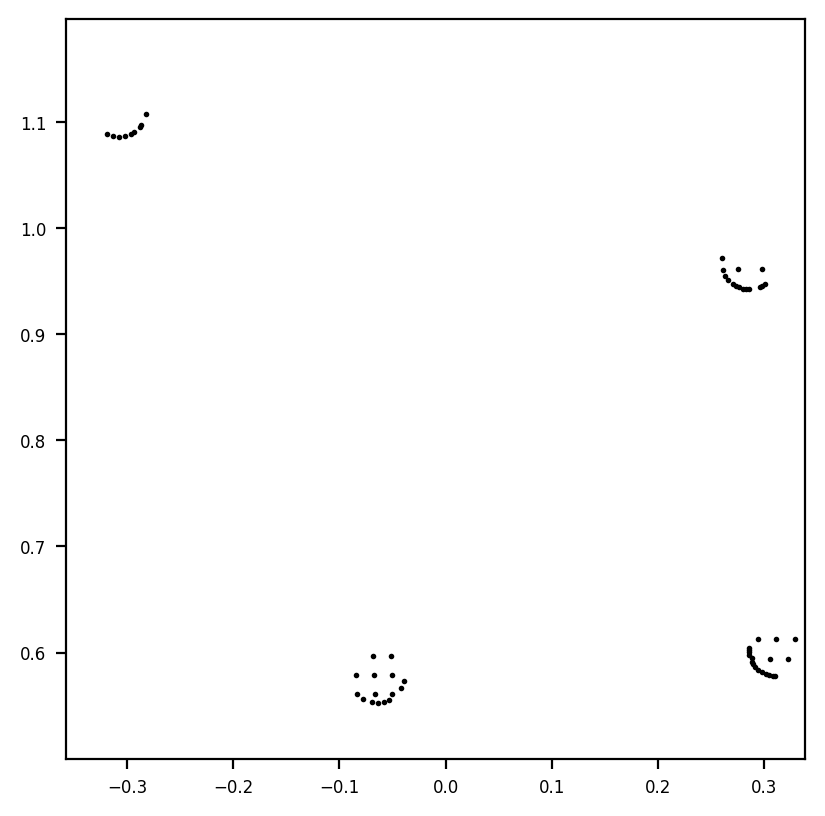

In [12]:
# %%
edge = 0.01
image_path = "./data/proj_xy_pcd.png"
# Set the range limits for the passthrough filter along a specific axis
axis = 2  # 0 for x-axis, 1 for y-axis, 2 for z-axis
min_limit = 0.9
max_limit = 1.5

# Apply the passthrough filter along the specified axis
filtered_pcd = pcd[(pcd[:, axis] >= min_limit) & (pcd[:, axis] <= max_limit)]
ax, fig, XY_info = project_XY(filtered_pcd, edge = 0.01, SAVE= image_path)
plt.show()

def detect_circle(image_path):
    # Load image
    partial_image = cv2.imread(image_path, 0)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(partial_image, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred_image, 30, 100)

    # Find contours in the edge image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables for circle detection using RANSAC
    best_circle = None
    max_inliers = 0
    num_iterations = 1000
    threshold_distance = 0.3  # Adjust this value based on the expected circle size

    # Perform RANSAC iterations
    for _ in range(num_iterations):
        # Randomly select three points from the contours
        random_points = np.random.choice(len(contours), 100, replace=True)
        points = [contours[i][0] for i in random_points]

        # Fit a circle using the selected points
        (x, y), radius = cv2.minEnclosingCircle(np.array(points))
        center = (int(x), int(y))
        radius = int(radius)

        # Count inliers (points within threshold distance to the circle)
        inliers = sum(cv2.pointPolygonTest(contour, center, True) <= threshold_distance for contour in contours)

        # Update the best circle if more inliers are found
        if inliers > max_inliers:
            max_inliers = inliers
            best_circle = (center, radius)

    # Draw the best circle on the original image
    if best_circle is not None:
        center, radius = best_circle
        cv2.circle(partial_image, center, radius, (0, 255, 0), 2)

    # Display the result
    plt.imshow(partial_image, cmap='gray')
    return partial_image, center, radius

partial_image, center_pixel, radius_pixel = detect_circle(image_path)
scale_rate = 2*(XY_info['radius']+XY_info['edge'])/partial_image.shape[0]

center_x = center_pixel[0] * scale_rate + XY_info['center_x'] - (XY_info['radius']+edge)
center_y = -center_pixel[1] * scale_rate + XY_info['center_y'] + (XY_info['radius']+edge)
radius = radius_pixel * scale_rate

project_XY(filtered_pcd, edge = 0.01, SAVE= image_path)
circle = plt.Circle((center_x, center_y), radius, fill=False)
ax.add_artist(circle)
plt.show()

In [13]:
import open3d as o3d

pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points = o3d.utility.Vector3dVector(filtered_pcd)
o3d.visualization.draw_geometries([pcd_o3d])

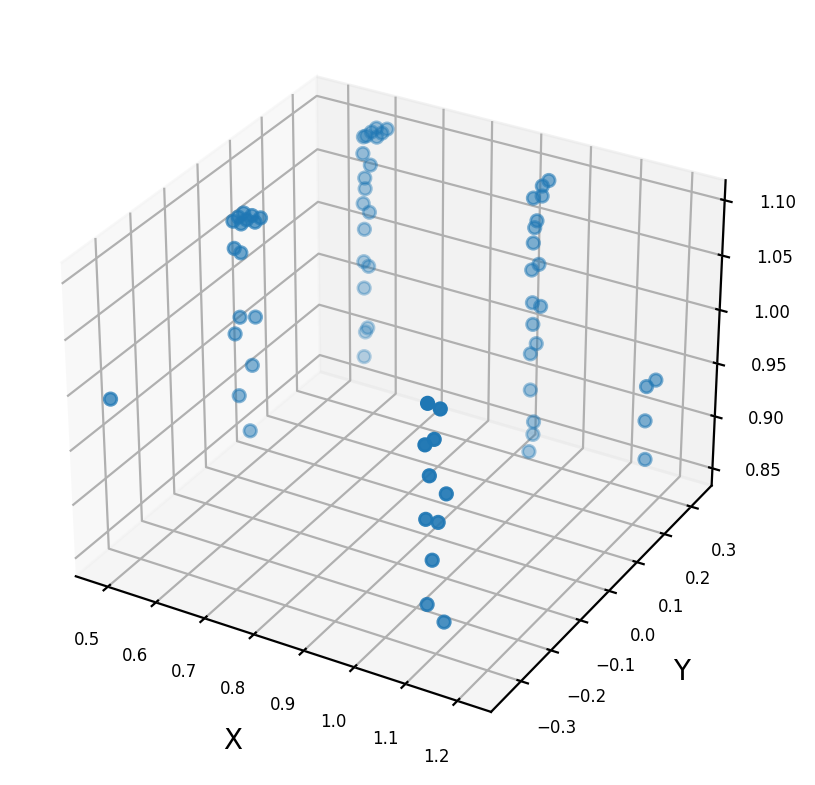

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your point cloud is stored in a NumPy array with shape [N x 3]
point_cloud = pcd

# Set the range limits for the passthrough filter along a specific axis
axis = 2  # 0 for x-axis, 1 for y-axis, 2 for z-axis
min_limit = 0.85
max_limit = 1.5

# Apply the passthrough filter along the specified axis
filtered_cloud = point_cloud[(point_cloud[:, axis] >= min_limit) & (point_cloud[:, axis] <= max_limit)]

# Extract the XYZ coordinates and RGB colors from the filtered point cloud
filtered_xyz = filtered_cloud[:, :3]
filtered_rgb = filtered_cloud[:, 3:]

# Plot the colored point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(filtered_xyz[:, 0], filtered_xyz[:, 1], filtered_xyz[:, 2])

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits
# ax.set_xlim(min_limit, max_limit)
# ax.set_ylim(min_limit, max_limit)
# ax.set_zlim(min_limit, max_limit)

# Show the plot
plt.show()


In [ ]:
import pyvista as pv

# Assuming you have a numpy array called 'point_cloud' with shape (N, 3)
cloud = pv.PolyData(filtered_pcd)
cloud.plot(point_size=5)


INFO - 2023-06-05 17:39:32,511 - __init__ - awaiting runner setup
INFO - 2023-06-05 17:39:32,594 - __init__ - awaiting site startup
INFO - 2023-06-05 17:39:32,595 - __init__ - awaiting running future


Widget(value="<iframe src='http://localhost:33709/index.html?ui=P_0x7f613679ad90_0&reconnect=auto' style='widt…

INFO - 2023-06-05 17:39:32,696 - web_log - 127.0.0.1 [05/Jun/2023:08:39:32 +0000] "GET /index.html?ui=P_0x7f613679ad90_0&reconnect=auto HTTP/1.1" 200 235 "-" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.77.1 Chrome/102.0.5005.196 Electron/19.1.11 Safari/537.36"
INFO - 2023-06-05 17:39:32,703 - web_log - 127.0.0.1 [05/Jun/2023:08:39:32 +0000] "GET /vue.global.js HTTP/1.1" 200 252 "http://localhost:33709/index.html?ui=P_0x7f613679ad90_0&reconnect=auto" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.77.1 Chrome/102.0.5005.196 Electron/19.1.11 Safari/537.36"
INFO - 2023-06-05 17:39:32,704 - web_log - 127.0.0.1 [05/Jun/2023:08:39:32 +0000] "GET /css/app.0b077e70.css HTTP/1.1" 200 234 "http://localhost:33709/index.html?ui=P_0x7f613679ad90_0&reconnect=auto" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.77.1 Chrome/102.0.5005.196 Electron/19.1.11 Safari/537.36"
INFO - 2023-06-05 17:39:32,705 - we

In [ ]:
import pyvista as pv

# Assuming you have a numpy array called 'point_cloud' with shape (N, 3)
cloud = pv.PolyData(point_cloud)
cloud.plot(point_size=5)

Widget(value="<iframe src='http://localhost:33709/index.html?ui=P_0x7f6125557df0_1&reconnect=auto' style='widt…

INFO - 2023-06-05 17:39:35,730 - web_log - 127.0.0.1 [05/Jun/2023:08:39:35 +0000] "GET /index.html?ui=P_0x7f6125557df0_1&reconnect=auto HTTP/1.1" 200 235 "-" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.77.1 Chrome/102.0.5005.196 Electron/19.1.11 Safari/537.36"
INFO - 2023-06-05 17:39:35,742 - web_log - 127.0.0.1 [05/Jun/2023:08:39:35 +0000] "POST /paraview/ HTTP/1.1" 405 207 "http://localhost:33709/index.html?ui=P_0x7f6125557df0_1&reconnect=auto" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.77.1 Chrome/102.0.5005.196 Electron/19.1.11 Safari/537.36"
INFO - 2023-06-05 17:39:35,756 - __init__ - client 3886679c096f4a36bfd290de61bcbac1 connected


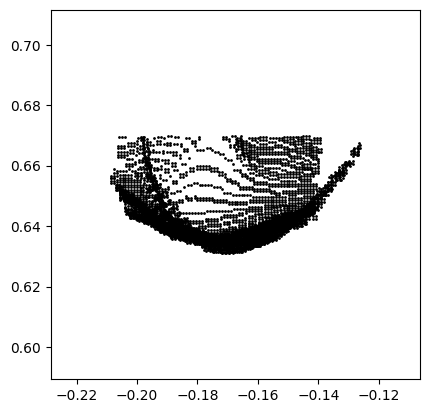

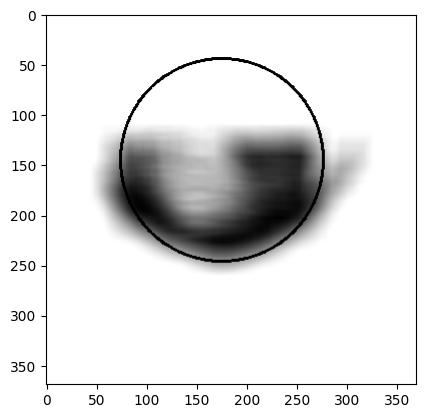

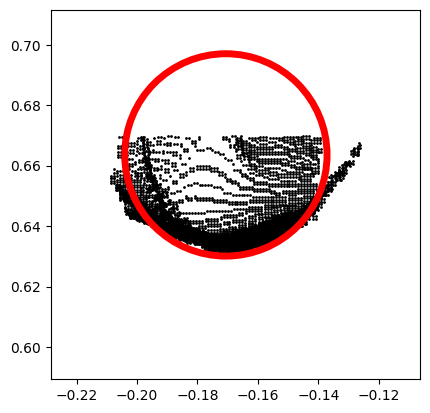

In [22]:
import cv2
import numpy as np

edge = 0.01

cleaned_point_cloud_list = np.load('./cleaned_point_cloud_list1.npy', allow_pickle=True)

edge = 0.01

def detect_hough(image_path):
    # Load image
    partial_image = cv2.imread(image_path, 0)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(partial_image, (33,33), 250)

    dp = 10.0  # Inverse ratio of the accumulator resolution to the image resolution (1 means same resolution)
    min_dist = 500  # Minimum distance between the centers of the detected circles
    param1 = 10  # Upper threshold for the internal Canny edge detector
    param2 = 5  # Threshold for center detection (lower value for more circles)
    min_radius = 70  # Minimum circle radius
    max_radius = 140  # Maximum circle radius (0 for no limit)

    circles = cv2.HoughCircles(blurred_image, cv2.HOUGH_GRADIENT, dp, min_dist,
                               param1=param1, param2=param2,
                               minRadius=min_radius, maxRadius=max_radius)


    # Draw detected circles on the original image
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]
            cv2.circle(blurred_image, center, radius, (0, 255, 0), 2)
    else: print("No Circles!")

    # Display the result
    plt.imshow(blurred_image, cmap='gray')
    return partial_image, center, radius

z_hard = 0.07
edge = 0.02

image_path = "XY.png"
ax, fig, XY_info = project_XY(cleaned_point_cloud_list, edge, SAVE=image_path)
plt.show()

partial_image, center_pixel, radius_pixel = detect_hough("XY.png")
scale_rate = 2*(XY_info['radius']+XY_info['edge'])/partial_image.shape[0]

center_x = center_pixel[0] * scale_rate + XY_info['center_x'] - (XY_info['radius']+edge)
center_y = -1 * center_pixel[1] * scale_rate + XY_info['center_y'] + (XY_info['radius']+edge)
radius = radius_pixel * scale_rate

ax, fig, XY_info = project_XY(cleaned_point_cloud_list, edge=edge, SAVE=None)
circle = plt.Circle((center_x, center_y), radius, fill=False, color='r', lw=5)
ax.add_artist(circle)
plt.show()

In [17]:
import numpy as np
import pyvista as pv

# Number of points
num_points = 1000

# Generate random 3D points
points = np.random.rand(num_points, 3)

# Generate random colors (RGB) for each point
colors = np.random.rand(num_points, 3)

# Create the point cloud using PyVista
cloud = pv.PolyData(points)

# Assign colors to the point cloud
cloud['colors'] = colors

# Create a plotter
plotter = pv.Plotter()

# Add the point cloud to the plotter
plotter.add_points(cloud, scalars='colors', rgb=True)

# Show the plot
plotter.show()


Widget(value="<iframe src='http://localhost:33709/index.html?ui=P_0x7f613678a9a0_2&reconnect=auto' style='widt…

INFO - 2023-06-05 17:39:46,937 - web_log - 127.0.0.1 [05/Jun/2023:08:39:46 +0000] "GET /index.html?ui=P_0x7f613678a9a0_2&reconnect=auto HTTP/1.1" 200 235 "-" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.77.1 Chrome/102.0.5005.196 Electron/19.1.11 Safari/537.36"
INFO - 2023-06-05 17:39:46,965 - web_log - 127.0.0.1 [05/Jun/2023:08:39:46 +0000] "POST /paraview/ HTTP/1.1" 405 207 "http://localhost:33709/index.html?ui=P_0x7f613678a9a0_2&reconnect=auto" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.77.1 Chrome/102.0.5005.196 Electron/19.1.11 Safari/537.36"
INFO - 2023-06-05 17:39:46,975 - __init__ - client 28878bddd7194c1e825bf7136c4da2fc connected
INFO - 2023-06-05 17:41:08,728 - web_log - 127.0.0.1 [05/Jun/2023:08:41:08 +0000] "GET /__trame_vuetify/fonts/roboto-latin-400.1e2d4d3a.woff2 HTTP/1.1" 200 238 "http://localhost:33709/__trame_vuetify/trame-vuetify.css" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, lik

In [20]:
import numpy as np
import pyvista as pv

# Let's assume 'depth_map' is your 2D depth map and 'rgb_image' is your 3D RGB image
# They should be numpy arrays with shapes (height, width) and (height, width, 3) respectively

height, width = depth_img.shape

# Create meshgrid for pixel coordinates
x, y = np.meshgrid(np.arange(width), np.arange(height))

# Create 3D array of coordinates; depth map provides the Z coordinate
# You may need to scale/normalize the depth map values depending on their range
points = np.dstack((x, y, depth_img))

# Flatten the points and colors arrays for PyVista
points = points.reshape(-1, 3)
colors = rgb_img.reshape(-1, 3)

# Handle the color range
# Pyvista expects colors to be in range [0, 1] for floats or [0, 255] for ints
if colors.dtype == np.float32 or colors.dtype == np.float64:
    colors = np.clip(colors, 0.0, 1.0)
else:
    colors = np.clip(colors, 0, 255)

# Create the point cloud using PyVista
cloud = pv.PolyData(points)

# Assign colors to the point cloud
cloud['colors'] = colors

# Create a plotter
plotter = pv.Plotter()

# Add the point cloud to the plotter
plotter.add_points(cloud, scalars='colors', rgb=True)

# Show the plot
plotter.show()


Widget(value="<iframe src='http://localhost:33709/index.html?ui=P_0x7f61254d37f0_4&reconnect=auto' style='widt…

INFO - 2023-06-05 17:42:10,930 - web_log - 127.0.0.1 [05/Jun/2023:08:42:10 +0000] "GET /index.html?ui=P_0x7f61254d37f0_4&reconnect=auto HTTP/1.1" 200 235 "-" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.77.1 Chrome/102.0.5005.196 Electron/19.1.11 Safari/537.36"
INFO - 2023-06-05 17:42:10,950 - web_log - 127.0.0.1 [05/Jun/2023:08:42:10 +0000] "POST /paraview/ HTTP/1.1" 405 207 "http://localhost:33709/index.html?ui=P_0x7f61254d37f0_4&reconnect=auto" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.77.1 Chrome/102.0.5005.196 Electron/19.1.11 Safari/537.36"
INFO - 2023-06-05 17:42:10,954 - __init__ - client 7844b8c060a94a45ab1f30a0f99d7f75 connected


In [21]:
point_cloud

array([[ 2.44,  1.54,  0.  ],
       [ 2.44,  1.47,  0.  ],
       [ 2.44,  1.39,  0.  ],
       ...,
       [ 0.52, -0.41,  0.8 ],
       [ 0.64, -0.87,  0.  ],
       [ 0.49, -0.35,  0.99]])

(960000, 3)

In [25]:
points.shape

(1040, 3)

In [30]:
import numpy as np
import pyvista as pv

rsz_rate = 30
h_rsz,w_rsz = depth_img.shape[0]//rsz_rate,depth_img.shape[1]//rsz_rate
depth_img_rsz = cv2.resize(depth_img,(w_rsz,h_rsz),interpolation=cv2.INTER_NEAREST)
rgb_img_rsz = cv2.resize(rgb_img,(w_rsz,h_rsz),interpolation=cv2.INTER_NEAREST)

# Flatten the points and colors arrays for PyVista
points = point_cloud.reshape(-1, 3)
colors = rgb_img_rsz.reshape(-1, 3)

# Handle the color range
# Pyvista expects colors to be in range [0, 1] for floats or [0, 255] for ints
if colors.dtype == np.float32 or colors.dtype == np.float64:
    colors = np.clip(colors, 0.0, 1.0)
else:
    colors = np.clip(colors, 0, 255)

# Create the point cloud using PyVista
cloud = pv.PolyData(points)

# Assign colors to the point cloud
cloud['colors'] = colors

# Create a plotter
plotter = pv.Plotter()

# Add the point cloud to the plotter
plotter.add_points(cloud, scalars='colors', rgb=True)

# Show the plot
plotter.show()


Widget(value="<iframe src='http://localhost:33709/index.html?ui=P_0x7f612672fee0_5&reconnect=auto' style='widt…

INFO - 2023-06-05 17:47:47,536 - web_log - 127.0.0.1 [05/Jun/2023:08:47:47 +0000] "GET /index.html?ui=P_0x7f612672fee0_5&reconnect=auto HTTP/1.1" 200 235 "-" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.77.1 Chrome/102.0.5005.196 Electron/19.1.11 Safari/537.36"
INFO - 2023-06-05 17:47:47,572 - web_log - 127.0.0.1 [05/Jun/2023:08:47:47 +0000] "POST /paraview/ HTTP/1.1" 405 207 "http://localhost:33709/index.html?ui=P_0x7f612672fee0_5&reconnect=auto" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.77.1 Chrome/102.0.5005.196 Electron/19.1.11 Safari/537.36"
INFO - 2023-06-05 17:47:47,576 - __init__ - client 51a16be3a20a42d9bcea7439e5cbc5b2 connected
